In [282]:
import json
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import warnings


In [283]:
training_challenge_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
training_solutions_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_solutions.json'))

In [284]:
def create_input_output_pairs(training_challenge_dict, training_solutions_dict):
    input_output_pairs = []
    
    for challenge_id, challenge in training_challenge_dict.items():
        train = challenge['train']
        test = challenge['test']

        # find how many examples there are in the train
        num_train_examples = len(train)

        for i in range(num_train_examples):
            input_output_pairs.append({
                'input': train[i]['input'],
                'output': train[i]['output'],
                'challenge_id': challenge_id,
            })

        test_input = test[0]['input']
        test_output = training_solutions_dict[challenge_id][0]
        input_output_pairs.append({
            'input': test_input,
            'output': test_output,
            'challenge_id': challenge_id,
        })
        
    return input_output_pairs

input_output_pairs = create_input_output_pairs(training_challenge_dict, training_solutions_dict)

In [285]:
def create_dataset(training_challenge_dict, training_solutions_dict):
    dict = {
        'input': [],
        'output': [],
        'challenge_id': []
    }

    for challenge_id, challenge in training_challenge_dict.items():
        train = challenge['train']
        test = challenge['test']

        for i in range(len(train)):
            dict['input'].append(torch.tensor(train[i]['input'], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
            dict['output'].append(torch.tensor(train[i]['output'], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
            dict['challenge_id'].append(challenge_id)

        dict['input'].append(torch.tensor(test[0]['input'], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
        dict['output'].append(torch.tensor(training_solutions_dict[challenge_id][0], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
        dict['challenge_id'].append(challenge_id)

    return pd.DataFrame(dict)

dataset = create_dataset(training_challenge_dict, training_solutions_dict)

In [286]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        k1, p1 = 2, 1
        k2, p2 = 2, 1
        k3, p3 = 2, 1
        pool_size = 2
        pool_stride = 2

        self.conv1 = nn.Conv2d(1, 32, kernel_size=k1, padding=p1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=k2, padding=p2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=k3, padding=p3)
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_stride)
        
        # Calculate the size of the feature maps after convolutions and pooling
        h1 = input_dim[2] + 2*p1 - (k1-1)
        w1 = input_dim[3] + 2*p1 - (k1-1)
        h2 = h1 + 2*p2 - (k2-1)
        w2 = w1 + 2*p2 - (k2-1)
        h3 = h2 + 2*p3 - (k3-1)
        w3 = w2 + 2*p3 - (k3-1)
        hpool = (h3 - (pool_size-1) - 1) // pool_stride + 1
        wpool = (w3 - (pool_size-1)-1) // pool_stride + 1

        #print('h1: ', h1, 'w1: ', w1, 'h2: ', h2, 'w2: ', w2, 'h3: ', h3, 'w3: ', w3, 'hpool: ', hpool, 'wpool: ', wpool)

        # calculate the output size of the conv layers
        conv_output_size = hpool * wpool * 64

        #print('conv_output_size: ', conv_output_size)
        
        self.fc1 = nn.Linear(conv_output_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_dim[2] * output_dim[3])

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        #print('x after conv1', x.shape)
        x = torch.relu(self.conv2(x))
        #print('x after conv2', x.shape)
        x = torch.relu(self.conv3(x))
        #print('x after conv3', x.shape)
        x = self.pool(x)
        #print('x after pool', x.shape)
        x = x.view(x.size(0), -1)
        #print('x after view', x.shape)
        x = torch.relu(self.fc1(x))
        #print('x after fc1', x.shape)
        x = torch.relu(self.fc2(x))
        #print('x after fc2', x.shape)
        x = self.fc3(x)
        return x.view(-1, self.output_dim[2], self.output_dim[3])
    
def train(model, inputs, outputs, num_epochs=300, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for i in range(len(inputs)):
            input_tensor = inputs[i]
            output_tensor = outputs[i]
            
            # Forward pass
            prediction = model(input_tensor)
            loss = criterion(prediction, output_tensor)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(inputs)
        if (epoch + 1) % num_epochs == 0:
            #print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
            pass
    
    return model

# Function to make predictions
def predict(model, input_data):
    # ignore warnings
    warnings.filterwarnings("ignore")
    model.eval()
    with torch.no_grad():
        input_tensor = input_data.clone().detach()
        output = model(input_tensor)

    output = output.squeeze().numpy()

    # round the output to the nearest integer
    output = np.round(output).astype(int)
    
    return output

In [287]:
from sklearn.preprocessing import MaxAbsScaler

trained_models = {
    'challenge_id': [],
    'model': [],
    'fc2_weights': [],
    'accuracy': []
}

# unpack the items of the dataset in a loop
i = 0

num_challenges = len(dataset)

while i < len(dataset):

    # print progress i/num_challenges * 100 deleting the last line
    print(f'{i}/{num_challenges} {i/num_challenges * 100:.2f}%', end='\r')


    inputs = [dataset.iloc[i]['input']]
    outputs = [dataset.iloc[i]['output']]

    challenge_id = dataset.iloc[i]['challenge_id']

    k = i+1

    while k < len(dataset) and dataset.iloc[k]['challenge_id'] == challenge_id and inputs[-1].shape == dataset.iloc[k]['input'].shape and outputs[-1].shape == dataset.iloc[k]['output'].shape:
        inputs.append(dataset.iloc[k]['input'])
        outputs.append(dataset.iloc[k]['output'])
        k += 1

    model = CNN(inputs[0].shape, outputs[0].shape)

    try:
        trained_model = train(model, inputs, outputs)
    except:
        raise Exception('Error in training the model with challenge_id: ', challenge_id)
        

    correct = 0

    for j in range(len(inputs)):

        # predict the output
        try:
            prediction = predict(trained_model, inputs[j])
        except:
            raise Exception('Error in training the model with challenge_id: ', challenge_id)

        correct_output = outputs[j].squeeze().numpy().astype(int)

        if np.array_equal(prediction, correct_output):
            correct += 1

        else:
            #print('prediction', prediction)
            #print('output', correct_output)
            pass

    # Extract the weights of the fc2 layer
    fc2_weights = trained_model.fc2.weight.data
    fc2_weights_numpy = fc2_weights.cpu().numpy()  # Convert to NumPy array if needed
    fc2_weights_numpy = fc2_weights_numpy.flatten() # reshape into a 1D array
    max_weight = np.max(np.abs(fc2_weights_numpy))
    scaled_fc2_weights = fc2_weights_numpy / max_weight


    # add to the trained_models dict
    trained_models['challenge_id'].append(challenge_id)
    trained_models['model'].append(trained_model)
    trained_models['fc2_weights'].append(scaled_fc2_weights)
    trained_models['accuracy'].append(correct / len(inputs))

    i = k + 1

trained_models_df = pd.DataFrame(trained_models)

In [288]:
# inspect the shape of the first weight
trained_models_df['fc2_weights'][0].shape

(1024,)

Mean accuracy:  0.9916252759381899
Median accuracy:  1.0
Min accuracy:  0.0
Max accuracy:  1.0


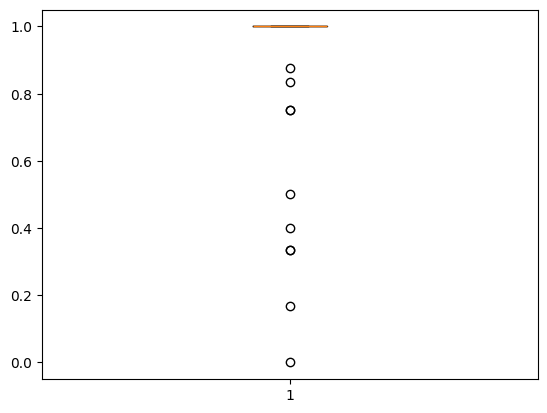

In [289]:
print('Mean accuracy: ', trained_models_df['accuracy'].mean())
print('Median accuracy: ', trained_models_df['accuracy'].median())
print('Min accuracy: ', trained_models_df['accuracy'].min())
print('Max accuracy: ', trained_models_df['accuracy'].max())


# boxplot of the accuracies
import matplotlib.pyplot as plt

plt.boxplot(trained_models_df['accuracy'])
plt.show()


In [290]:
num_models = len(trained_models_df)

# create a ndarray to store distances between models
distances = np.zeros((num_models, num_models))

# calculate the distances between the models
for i in range(num_models):
    for j in range(num_models):
        if i == j:
            distances[i, j] = 0
        else:
            # calculate euclidean distance between the two models
            distances[i, j] = np.linalg.norm(trained_models_df['fc2_weights'][i] - trained_models_df['fc2_weights'][j])

not_zero_distances = distances[distances != 0]

print('Mean distance: ', not_zero_distances.mean())
print('Median distance: ', np.median(not_zero_distances))
print('Min distance: ', not_zero_distances.min())
print('Max distance: ', not_zero_distances.max())

Mean distance:  22.21482205997627
Median distance:  22.355449676513672
Min distance:  12.640295028686523
Max distance:  26.826082229614258


Models with the same challenge_id:  227
Mean distance between models with the same challenge_id:  22.945426193102865
Median distance between models with the same challenge_id:  22.963272094726562
Min distance between models with the same challenge_id:  19.875211715698242
Max distance between models with the same challenge_id:  25.943817138671875


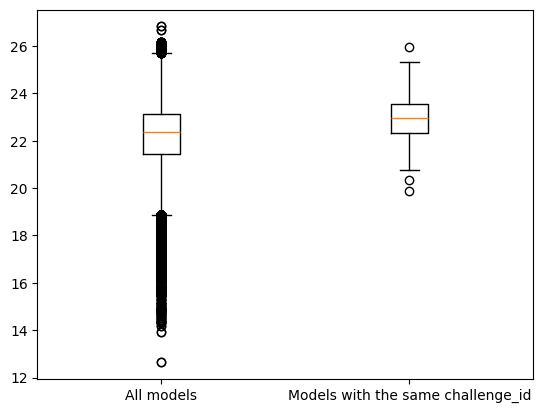

In [291]:
same_key_distances = []
for i in range(num_models):
    for j in range(i+1, num_models):
        if trained_models_df['challenge_id'][i] == trained_models_df['challenge_id'][j]:
            same_key_distances.append(distances[i, j])

print('Models with the same challenge_id: ', len(same_key_distances))
print('Mean distance between models with the same challenge_id: ', np.mean(same_key_distances))
print('Median distance between models with the same challenge_id: ', np.median(same_key_distances))
print('Min distance between models with the same challenge_id: ', np.min(same_key_distances))
print('Max distance between models with the same challenge_id: ', np.max(same_key_distances))

# double boxplot of the distances
plt.boxplot([not_zero_distances, same_key_distances])
plt.xticks([1, 2], ['All models', 'Models with the same challenge_id'])
plt.show()